In [1]:
from __future__ import print_function
import os
import zipfile
import plaidml.keras
plaidml.keras.install_backend()
import keras
import numpy as np
import pandas as pd
from collections import Counter
from datetime import datetime


In [2]:
train = pd.read_csv("Dataset/train.csv")
test = pd.read_csv("Dataset/test.csv")

In [3]:
train.drop(['breed_category','pet_category'],axis=1)
dataset = pd.concat([train.drop(['breed_category','pet_category'],axis=1),test])
dataset['issue_date'] = pd.to_datetime(dataset['issue_date'])
dataset['listing_date'] = pd.to_datetime(dataset['listing_date'])
dataset['duration'] = (dataset['listing_date'] - dataset['issue_date']).dt.days  
dataset = dataset.drop(['issue_date','listing_date'],axis=1)
dataset 

,pet_id,condition,color_type,length(m),height(cm),X1,X2,duration
0,ANSL_69903,2.0,Brown Tabby,0.80,7.78,13,9,73
1,ANSL_66892,1.0,White,0.72,14.19,13,9,1862
2,ANSL_69750,NaN,Brown,0.15,40.90,15,4,752
3,ANSL_71623,1.0,White,0.62,17.82,0,1,755
4,ANSL_57969,2.0,Black,0.50,11.06,18,4,52
...,...,...,...,...,...,...,...,...
8067,ANSL_66809,2.0,Brown,0.82,36.08,13,9,394
8068,ANSL_59041,0.0,Tan,0.49,27.54,13,9,798
8069,ANSL_60034,0.0,Black,0.98,37.19,0,7,393
8070,ANSL_58066,NaN,Black,0.79,23.83,0,2,387


In [4]:
dataset=dataset.reset_index(drop=True)

In [7]:
info = pd.DataFrame()
info['length(m)'] = [np.percentile(dataset['length(m)'],25*i) for i in range(1,4)]
info['height(cm)'] = [np.percentile(dataset['height(cm)'],25*i) for i in range(1,4)]
info['duration'] = [np.percentile(dataset['duration'],25*i) for i in range(1,4)]
info
info.loc[3] = [2.5*info.loc[0,column] - 1.5*info.loc[2,column] for column in info.columns]
info.loc[4] = [2.5*info.loc[2,column] - 1.5*info.loc[0,column] for column in info.columns]
info
def range_part(column,value):
    if value > info.loc[4,column]:
        return 5
    elif value > info.loc[2,column]:
        return 4
    elif value > info.loc[1,column]:
        return 3
    elif value > info.loc[0,column]:
        return 2
    elif value > info.loc[3,column]:
        return 1
    else:
        return 0
dataset.dtypes

pet_id         object
condition     float64
color_type     object
length(m)     float64
height(cm)    float64
X1              int64
X2              int64
duration        int64
dtype: object

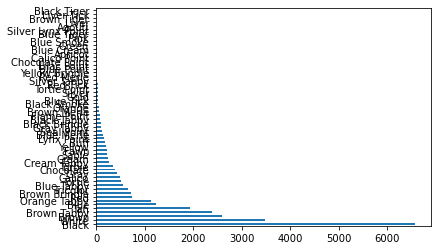

In [8]:
df = dataset['color_type'].value_counts().plot(kind='barh')
df.plot(figsize=(10,10));

In [9]:
numerical = dataset.dtypes[dataset.dtypes != object].index

<AxesSubplot:>

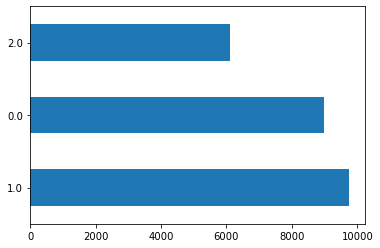

In [10]:
dataset['condition'].value_counts().plot(kind='barh')

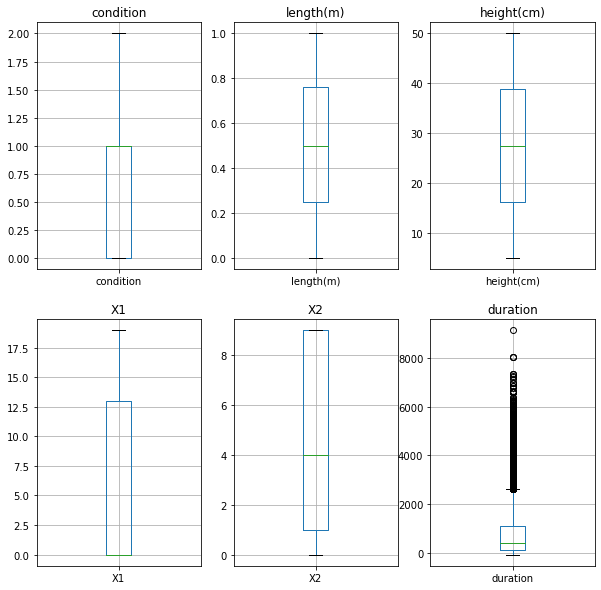

In [11]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,3,figsize=(10,10))

for i in range(3):
    dataset.boxplot(column=list(numerical)[i], ax=ax[0,i])
    ax[0,i].title.set_text(numerical[i])

for i in range(3):
    dataset.boxplot(column=list(numerical)[i+3], ax=ax[1,i])
    ax[1,i].title.set_text(numerical[3+i])

In [12]:
from tqdm import tqdm
tqdm.pandas()
dataset['length_range'] = dataset['length(m)'].progress_apply(lambda x:range_part('length(m)',x))
dataset['height_range'] = dataset['height(cm)'].progress_apply(lambda x:range_part('height(cm)',x))
dataset['duration_range'] = dataset['duration'].progress_apply(lambda x:range_part('duration',x))
dataset

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26906/26906 [00:01<00:00, 14356.48it/s]


,pet_id,condition,color_type,length(m),height(cm),X1,X2,duration,length_range,height_range,duration_range
0,ANSL_69903,2.0,Brown Tabby,0.80,7.78,13,9,73,4,1,1
1,ANSL_66892,1.0,White,0.72,14.19,13,9,1862,3,1,4
2,ANSL_69750,NaN,Brown,0.15,40.90,15,4,752,1,4,3
3,ANSL_71623,1.0,White,0.62,17.82,0,1,755,3,2,3
4,ANSL_57969,2.0,Black,0.50,11.06,18,4,52,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...
26901,ANSL_66809,2.0,Brown,0.82,36.08,13,9,394,4,3,3
26902,ANSL_59041,0.0,Tan,0.49,27.54,13,9,798,2,3,3
26903,ANSL_60034,0.0,Black,0.98,37.19,0,7,393,4,3,3
26904,ANSL_58066,NaN,Black,0.79,23.83,0,2,387,4,2,2


In [13]:
from sklearn.preprocessing import LabelEncoder
dataset['color_number'] = LabelEncoder().fit_transform(dataset['color_type'])
dataset = dataset[['condition','duration_range','color_number','X1','X2']].fillna(-1)
dataset

,condition,duration_range,color_number,X1,X2
0,2.0,1,18,13,9
1,1.0,4,53,13,9
2,-1.0,3,15,15,4
3,1.0,3,53,0,1
4,2.0,1,2,18,4
...,...,...,...,...,...
26901,2.0,3,15,13,9
26902,0.0,3,48,13,9
26903,0.0,3,2,0,7
26904,-1.0,2,2,0,2


In [16]:
X_tr, y_tr = dataset.iloc[:len(train)], train['breed_category']
X_test = dataset.iloc[len(train):]
z_tr = train['pet_category']


In [17]:
from xgboost import XGBClassifier
XGB = XGBClassifier()
XGB.fit(X_tr, y_tr)
y_XGB=XGB.predict(X_test)
XGB.fit(X_tr,z_tr)
z_XGB=XGB.predict(X_test)

In [24]:
submission = pd.DataFrame()
submission['pet_id'] = test['pet_id']
submission['breed_category'] = y_XGB
submission['pet_category'] = z_XGB
submission.to_csv('submission_NeuralNetwork.csv',index=False)

In [21]:
import xgboost as xgb

# Create XGB Classifier object
xgb_clf = xgb.XGBClassifier(tree_method = "exact", predictor = "cpu_predictor")

# Create parameter grid
parameters = {"learning_rate": [0.1, 0.01, 0.001],
               "gamma" : [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2],
               "max_depth": [2, 4, 7, 10],
               "colsample_bytree": [0.3, 0.6, 0.8, 1.0],
               "subsample": [0.2, 0.4, 0.5, 0.6, 0.7],
               "reg_alpha": [0, 0.5, 1],
               "reg_lambda": [1, 1.5, 2, 3, 4.5],
               "min_child_weight": [1, 3, 5, 7],
               "n_estimators": [100, 250, 500, 1000]}

from sklearn.model_selection import RandomizedSearchCV
# Create RandomizedSearchCV Object
xgb_rscv = RandomizedSearchCV(xgb_clf, param_distributions = parameters, scoring = "f1_micro",
                             cv = 10, verbose = 3, random_state = 40 )

# Fit the model
model_xgboost = xgb_rscv.fit(X_tr, y_tr)

# Model best estimators
print("Learning Rate: ", model_xgboost.best_estimator_.get_params()["learning_rate"])
print("Gamma: ", model_xgboost.best_estimator_.get_params()["gamma"])
print("Max Depth: ", model_xgboost.best_estimator_.get_params()["max_depth"])
print("Subsample: ", model_xgboost.best_estimator_.get_params()["subsample"])
print("Max Features at Split: ", model_xgboost.best_estimator_.get_params()["colsample_bytree"])
print("Alpha: ", model_xgboost.best_estimator_.get_params()["reg_alpha"])
print("Lamda: ", model_xgboost.best_estimator_.get_params()["reg_lambda"])
print("Minimum Sum of the Instance Weight Hessian to Make a Child: ",
      model_xgboost.best_estimator_.get_params()["min_child_weight"])
print("Number of Trees: ", model_xgboost.best_estimator_.get_params()["n_estimators"])

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] subsample=0.6, reg_lambda=1, reg_alpha=0, n_estimators=100, min_child_weight=5, max_depth=2, learning_rate=0.1, gamma=1.5, colsample_bytree=1.0 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  subsample=0.6, reg_lambda=1, reg_alpha=0, n_estimators=100, min_child_weight=5, max_depth=2, learning_rate=0.1, gamma=1.5, colsample_bytree=1.0, score=0.906, total=   1.4s
[CV] subsample=0.6, reg_lambda=1, reg_alpha=0, n_estimators=100, min_child_weight=5, max_depth=2, learning_rate=0.1, gamma=1.5, colsample_bytree=1.0 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV]  subsample=0.6, reg_lambda=1, reg_alpha=0, n_estimators=100, min_child_weight=5, max_depth=2, learning_rate=0.1, gamma=1.5, colsample_bytree=1.0, score=0.900, total=   1.6s
[CV] subsample=0.6, reg_lambda=1, reg_alpha=0, n_estimators=100, min_child_weight=5, max_depth=2, learning_rate=0.1, gamma=1.5, colsample_bytree=1.0 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.9s remaining:    0.0s


[CV]  subsample=0.6, reg_lambda=1, reg_alpha=0, n_estimators=100, min_child_weight=5, max_depth=2, learning_rate=0.1, gamma=1.5, colsample_bytree=1.0, score=0.899, total=   1.4s
[CV] subsample=0.6, reg_lambda=1, reg_alpha=0, n_estimators=100, min_child_weight=5, max_depth=2, learning_rate=0.1, gamma=1.5, colsample_bytree=1.0 
[CV]  subsample=0.6, reg_lambda=1, reg_alpha=0, n_estimators=100, min_child_weight=5, max_depth=2, learning_rate=0.1, gamma=1.5, colsample_bytree=1.0, score=0.901, total=   1.4s
[CV] subsample=0.6, reg_lambda=1, reg_alpha=0, n_estimators=100, min_child_weight=5, max_depth=2, learning_rate=0.1, gamma=1.5, colsample_bytree=1.0 
[CV]  subsample=0.6, reg_lambda=1, reg_alpha=0, n_estimators=100, min_child_weight=5, max_depth=2, learning_rate=0.1, gamma=1.5, colsample_bytree=1.0, score=0.914, total=   1.4s
[CV] subsample=0.6, reg_lambda=1, reg_alpha=0, n_estimators=100, min_child_weight=5, max_depth=2, learning_rate=0.1, gamma=1.5, colsample_bytree=1.0 
[CV]  subsample=

[CV]  subsample=0.2, reg_lambda=4.5, reg_alpha=0.5, n_estimators=250, min_child_weight=1, max_depth=2, learning_rate=0.001, gamma=0.5, colsample_bytree=1.0, score=0.898, total=   3.0s
[CV] subsample=0.2, reg_lambda=4.5, reg_alpha=0.5, n_estimators=250, min_child_weight=1, max_depth=2, learning_rate=0.001, gamma=0.5, colsample_bytree=1.0 
[CV]  subsample=0.2, reg_lambda=4.5, reg_alpha=0.5, n_estimators=250, min_child_weight=1, max_depth=2, learning_rate=0.001, gamma=0.5, colsample_bytree=1.0, score=0.892, total=   3.1s
[CV] subsample=0.2, reg_lambda=4.5, reg_alpha=0.5, n_estimators=250, min_child_weight=1, max_depth=2, learning_rate=0.001, gamma=0.5, colsample_bytree=1.0 
[CV]  subsample=0.2, reg_lambda=4.5, reg_alpha=0.5, n_estimators=250, min_child_weight=1, max_depth=2, learning_rate=0.001, gamma=0.5, colsample_bytree=1.0, score=0.874, total=   3.0s
[CV] subsample=0.7, reg_lambda=1, reg_alpha=0, n_estimators=100, min_child_weight=7, max_depth=4, learning_rate=0.1, gamma=0.1, colsampl

[CV]  subsample=0.7, reg_lambda=3, reg_alpha=1, n_estimators=100, min_child_weight=3, max_depth=10, learning_rate=0.001, gamma=0.01, colsample_bytree=0.6, score=0.899, total=   2.2s
[CV] subsample=0.7, reg_lambda=3, reg_alpha=1, n_estimators=100, min_child_weight=3, max_depth=10, learning_rate=0.001, gamma=0.01, colsample_bytree=0.6 
[CV]  subsample=0.7, reg_lambda=3, reg_alpha=1, n_estimators=100, min_child_weight=3, max_depth=10, learning_rate=0.001, gamma=0.01, colsample_bytree=0.6, score=0.906, total=   2.3s
[CV] subsample=0.7, reg_lambda=3, reg_alpha=1, n_estimators=100, min_child_weight=3, max_depth=10, learning_rate=0.001, gamma=0.01, colsample_bytree=0.6 
[CV]  subsample=0.7, reg_lambda=3, reg_alpha=1, n_estimators=100, min_child_weight=3, max_depth=10, learning_rate=0.001, gamma=0.01, colsample_bytree=0.6, score=0.911, total=   2.2s
[CV] subsample=0.7, reg_lambda=3, reg_alpha=1, n_estimators=100, min_child_weight=3, max_depth=10, learning_rate=0.001, gamma=0.01, colsample_bytr

[CV]  subsample=0.4, reg_lambda=1.5, reg_alpha=0, n_estimators=1000, min_child_weight=1, max_depth=7, learning_rate=0.01, gamma=0.3, colsample_bytree=0.6, score=0.910, total=  19.4s
[CV] subsample=0.4, reg_lambda=1.5, reg_alpha=0, n_estimators=1000, min_child_weight=1, max_depth=7, learning_rate=0.01, gamma=0.3, colsample_bytree=0.6 
[CV]  subsample=0.4, reg_lambda=1.5, reg_alpha=0, n_estimators=1000, min_child_weight=1, max_depth=7, learning_rate=0.01, gamma=0.3, colsample_bytree=0.6, score=0.904, total=  18.9s
[CV] subsample=0.4, reg_lambda=1.5, reg_alpha=0, n_estimators=1000, min_child_weight=1, max_depth=7, learning_rate=0.01, gamma=0.3, colsample_bytree=0.6 
[CV]  subsample=0.4, reg_lambda=1.5, reg_alpha=0, n_estimators=1000, min_child_weight=1, max_depth=7, learning_rate=0.01, gamma=0.3, colsample_bytree=0.6, score=0.890, total=  19.2s
[CV] subsample=0.7, reg_lambda=3, reg_alpha=0, n_estimators=250, min_child_weight=7, max_depth=10, learning_rate=0.01, gamma=0.3, colsample_bytree

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  9.0min finished


Learning Rate:  0.1
Gamma:  0.1
Max Depth:  4
Subsample:  0.7
Max Features at Split:  1.0
Alpha:  0
Lamda:  1
Minimum Sum of the Instance Weight Hessian to Make a Child:  7
Number of Trees:  100


In [97]:
XGB = xgb.XGBClassifier(learning_rate=0.045,gamma=0.38,max_depth=4,subsample=0.6
                        ,reg_lambda=1,n_estimators=750,objective = "multi:softmax")
XGB.fit(X_tr, y_tr)
y_XGB=XGB.predict(X_test)
XGB.fit(X_tr,z_tr)
z_XGB=XGB.predict(X_test)

In [98]:
submission = pd.DataFrame()
submission['pet_id'] = test['pet_id']
submission['breed_category'] = y_XGB
submission['pet_category'] = z_XGB
submission.to_csv('submission_NeuralNetwork.csv',index=False)